In [ ]:
import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Age&Gender Model

In [3]:

# Initialize lists to store image paths, ages, and genders
images = []
ages = []
genders = []

# Path to the dataset
data_dir = '../input/utkface-new/UTKFace/'

# Process each image in the directory
for img_name in os.listdir(data_dir):
    if img_name.lower().endswith(('.jpg', '.png')):  # Process only image files
        split = img_name.split('_')
        if len(split) >= 3:
            try:
                age = int(split[0])
                gender = int(split[1])
                if 0 <= age <= 100:  # Filter ages not within the range
                    images.append(os.path.join(data_dir, img_name))
                    ages.append(age)
                    genders.append(gender)
            except ValueError:
                # Skip files where age or gender cannot be parsed
                continue


In [4]:
# Create a DataFrame
df = pd.DataFrame({'Image Path': images, 'Age': ages, 'Gender': genders})
df = df.reset_index(drop=True)

# Display the head of the DataFrame
print(df.head())

                                          Image Path  Age  Gender

0  ../input/utkface-new/UTKFace/26_0_2_2017010402...   26       0

1  ../input/utkface-new/UTKFace/22_1_1_2017011223...   22       1

2  ../input/utkface-new/UTKFace/21_1_3_2017010500...   21       1

3  ../input/utkface-new/UTKFace/28_0_0_2017011718...   28       0

4  ../input/utkface-new/UTKFace/17_1_4_2017010322...   17       1


In [48]:
# Save the DataFrame to a CSV file
csv_file_path = '/kaggle/working/utkface_data.csv'
df.to_csv(csv_file_path, index=False)

print(f"CSV file saved to: {csv_file_path}")


CSV file saved to: /kaggle/working/utkface_data.csv


In [5]:
print(f"Loaded {len(df)} images.")


Loaded 23687 images.


In [6]:
# Split the data
x_train, x_val, y_train_age, y_val_age = train_test_split(df['Image Path'], df['Age'], test_size=0.1, random_state=100)
x_train, x_val, y_train_gender, y_val_gender = train_test_split(df['Image Path'], df['Gender'], test_size=0.1, random_state=100)

df_train_age = pd.DataFrame({'Image Path': x_train, 'Age': y_train_age})
df_val_age = pd.DataFrame({'Image Path': x_val, 'Age': y_val_age})

df_train_gender = pd.DataFrame({'Image Path': x_train, 'Gender': y_train_gender})
df_val_gender = pd.DataFrame({'Image Path': x_val, 'Gender': y_val_gender})

print(f"Training set for age: {len(df_train_age)} samples")
print(f"Validation set for age: {len(df_val_age)} samples")
print(f"Training set for gender: {len(df_train_gender)} samples")
print(f"Validation set for gender: {len(df_val_gender)} samples")

Training set for age: 21318 samples

Validation set for age: 2369 samples

Training set for gender: 21318 samples

Validation set for gender: 2369 samples


In [7]:
# Parameters
img_size = 128
batch_size = 32

In [8]:
from tensorflow.keras.preprocessing import image
# Function to load and preprocess images
def load_and_preprocess_images(image_paths, img_size):
    images = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(img_size, img_size))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0, 1]
        images.append(img_array)
    return np.array(images)

# Load and preprocess images
x_train_images = load_and_preprocess_images(x_train, img_size)
x_val_images = load_and_preprocess_images(x_val, img_size)

# Encode the gender labels
le = LabelEncoder()
y_train_gender_enc = le.fit_transform(y_train_gender)
y_val_gender_enc = le.transform(y_val_gender)

# One-hot encode the gender labels
y_train_gender_enc = to_categorical(y_train_gender_enc, num_classes=2)
y_val_gender_enc = to_categorical(y_val_gender_enc, num_classes=2)

# Reshape age labels to match the input shape
y_train_age = np.array(y_train_age)
y_val_age = np.array(y_val_age)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to your training data
datagen.fit(x_train_images)


In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
def Age_gender_model(img_size):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Age prediction branch
    age_branch = Dense(128, activation='relu')(x)
    age_branch = Dropout(0.5)(age_branch)
    age_output = Dense(1, name='age_output')(age_branch)
    
    # Gender prediction branch
    gender_branch = Dense(128, activation='relu')(x)
    gender_branch = Dropout(0.5)(gender_branch)
    gender_output = Dense(2, activation='softmax', name='gender_output')(gender_branch)
    
    age_gender_model = Model(inputs=base_model.input, outputs=[age_output, gender_output])
    return age_gender_model


In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
model = Age_gender_model(img_size)

# Use a learning rate schedule
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Compile the model with a different learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss={'age_output': 'mse', 'gender_output': 'categorical_crossentropy'}, 
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})


In [26]:
# Define image size
img_size = 128  # or your desired size

# Instantiate the model

# Fit the model
history = model.fit(
    x=x_train_images, 
    y={'age_output': y_train_age, 'gender_output': y_train_gender_enc},
    validation_data=(x_val_images, {'age_output': y_val_age, 'gender_output': y_val_gender_enc}),
    epochs=40,
    batch_size=batch_size,
    verbose=1
)


Epoch 1/40



I0000 00:00:1723077237.179717    6396 service.cc:146] XLA service 0x7f31a4003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

I0000 00:00:1723077237.179785    6396 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5

I0000 00:00:1723077237.179791    6396 service.cc:154]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5

I0000 00:00:1723077266.967670    6396 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


667/667 ━━━━━━━━━━━━━━━━━━━━ 166s 155ms/step - age_output_mae: 12.1725 - gender_output_accuracy: 0.7035 - loss: 311.8974 - val_age_output_mae: 12.8399 - val_gender_output_accuracy: 0.5555 - val_loss: 273.9061

Epoch 2/40

667/667 ━━━━━━━━━━━━━━━━━━━━ 74s 111ms/step - age_output_mae: 6.4099 - gender_output_accuracy: 0.8175 - loss: 77.1947 - val_age_output_mae: 6.9283 - val_gender_output_accuracy: 0.8501 - val_loss: 96.7408

Epoch 3/40

667/667 ━━━━━━━━━━━━━━━━━━━━ 74s 111ms/step - age_output_mae: 5.8422 - gender_output_accuracy: 0.8475 - loss: 64.6838 - val_age_output_mae: 6.0725 - val_gender_output_accuracy: 0.8535 - val_loss: 75.6272

Epoch 4/40

667/667 ━━━━━━━━━━━━━━━━━━━━ 74s 111ms/step - age_output_mae: 5.4903 - gender_output_accuracy: 0.8603 - loss: 58.0525 - val_age_output_mae: 5.5134 - val_gender_output_accuracy: 0.8392 - val_loss: 65.3796

Epoch 5/40

667/667 ━━━━━━━━━━━━━━━━━━━━ 74s 111ms/step - age_output_mae: 5.0347 - gender_output_accuracy: 0.8681 - loss: 48.7733 - val_age

In [31]:


# Evaluate the model
test_results = model.evaluate(
    x=x_val_images,
    y={'age_output': y_val_age, 'gender_output': y_val_gender_enc}
)

print(f"Test Loss: {test_results[0]}")
print(f"Test Age MAE: {test_results[1]}")
print(f"Test Gender Accuracy: {test_results[2]}")


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - age_output_mae: 5.1168 - gender_output_accuracy: 0.9030 - loss: 52.7973

Test Loss: 55.712310791015625

Test Age MAE: 5.179800510406494

Test Gender Accuracy: 0.8986914157867432


In [33]:
from sklearn.metrics import r2_score

# Get predictions for the validation set
val_predictions = model.predict(x_val_images)
val_predictions_age = val_predictions[0]  # Assuming the age predictions are the first output
val_labels_age = y_val_age

# Calculate R² score
r2 = r2_score(val_labels_age, val_predictions_age)
print(f"R² score: {r2:.4f}")


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step

R² score: 0.8541


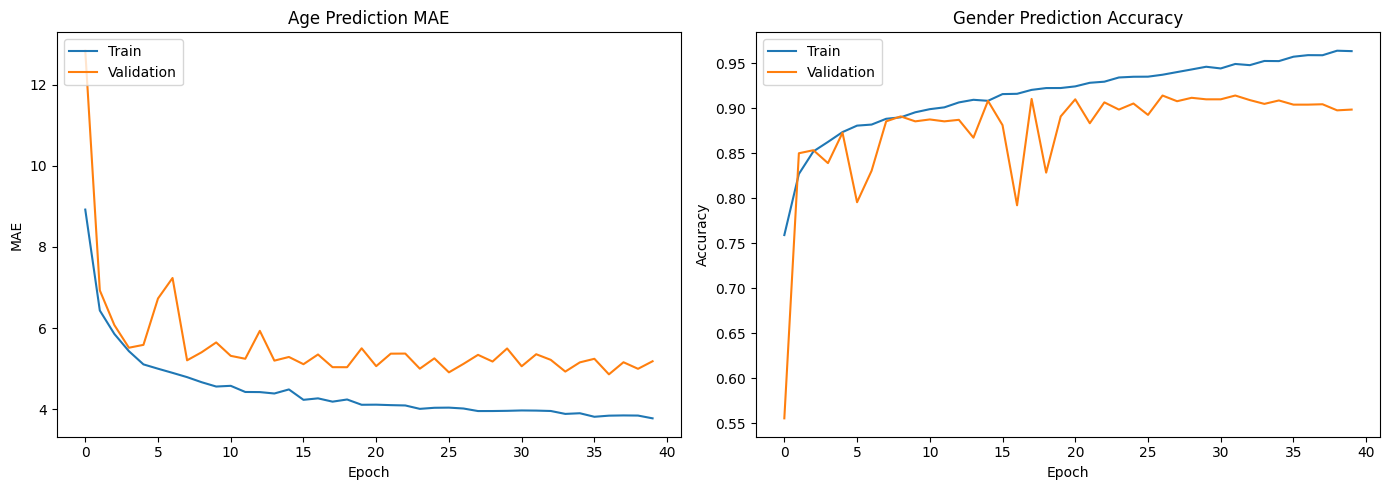

In [34]:
import matplotlib.pyplot as plt

# Plot training & validation MAE for age and accuracy for gender
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # MAE for age prediction
    axs[0].plot(history.history['age_output_mae'])
    axs[0].plot(history.history['val_age_output_mae'])
    axs[0].set_title('Age Prediction MAE')
    axs[0].set_ylabel('MAE')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Accuracy for gender prediction
    axs[1].plot(history.history['gender_output_accuracy'])
    axs[1].plot(history.history['val_gender_output_accuracy'])
    axs[1].set_title('Gender Prediction Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


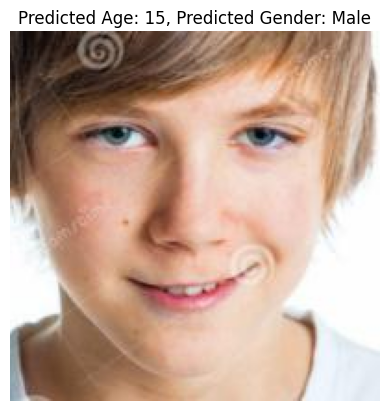

Predicted Age: 15

Predicted Gender: Male


In [64]:

def make_predictions(model, img_path, img_size):
    img_array = preprocess_image(img_path, img_size)
    age_pred, gender_pred = model.predict(img_array)
    
    # Post-process predictions
    age = int(np.round(age_pred[0][0]))  # Convert age to a whole number
    gender = np.argmax(gender_pred[0])
    
    gender_label = 'Male' if gender == 0 else 'Female'
    
    return age, gender_label

# Path to the new image
new_img_path = '/kaggle/input/utkface-new/UTKFace/10_0_0_20170110215927291.jpg.chip.jpg'
# Make predictions
predicted_age, predicted_gender = make_predictions(model, new_img_path, img_size)

# Load and plot the image
img = mpimg.imread(new_img_path)
plt.imshow(img)
plt.title(f"Predicted Age: {predicted_age}, Predicted Gender: {predicted_gender}")
plt.axis('off')  # Hide axes
plt.show()

# Display the prediction results
print(f"Predicted Age: {predicted_age}")
print(f"Predicted Gender: {predicted_gender}")